## ASL Project CNN Model Inference

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import src.image_processor as ip
from src.generator import train_generator

2023-05-28 20:04:52.424474: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-28 20:04:52.476466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 20:04:54.459138: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 1512 images belonging to 26 classes.


In [2]:
# Load the best trained CNN model
model_path = "./artifacts/best_model_84.h5"
model = load_model(model_path)

2023-05-28 20:05:02.240474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46671 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-05-28 20:05:02.241274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46671 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1b:00.0, compute capability: 8.6
2023-05-28 20:05:02.242001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46671 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:88:00.0, compute capability: 8.6
2023-05-28 20:05:02.242669: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46671 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:89:00.0, 

In [3]:
# Define necessary paths
test_folder = "./data/roboflow/raw/test"
processed_folder = "./data/roboflow/processed/test_bb/"
annotation_file = "./annotations/test_annotations.csv"

# Process test images
ip.process_images_direct(test_folder, 
                         processed_folder, 
                         annotation_file)

# Read the annotation file
annotations = pd.read_csv(annotation_file)

Skipping non-jpg file .ipynb_checkpoints


In [9]:
def test_model(model, annotations, processed_folder, train_generator):
    """
    Tests a trained model on preprocessed test images and saves the results.

    Args:
    - model: a trained Keras model
    - annotations: a pandas DataFrame containing the annotations for the test images
    - processed_folder: the path to the folder containing the preprocessed test images
    - train_generator: the ImageDataGenerator used to generate the training data

    Returns:
    - The accuracy of the model on the test data.
    """
    # Initialize the counter for correct predictions
    correct_predictions = 0

    # Create empty lists for images and predictions
    images = []
    predictions = []
    ground_truths = []

    # Iterate through all images in the test folder
    for file in os.listdir(processed_folder):

        output_image_path = os.path.join(processed_folder, file)

        # Load the preprocessed image and convert it to an array
        test_image = load_img(output_image_path, target_size=(64, 64))
        test_image_array = img_to_array(test_image)

        # Preprocess the image array
        test_image_array = test_image_array / 255.0
        test_image_array = np.expand_dims(test_image_array, axis=0)

        # Make a prediction
        predictions_ = model.predict(test_image_array)

        # Find the class with the highest probability
        predicted_class_index = np.argmax(predictions_[0])

        # Retrieve the corresponding label
        class_indices = train_generator.class_indices
        index_to_class_name = {index: name for name, index in class_indices.items()}
        predicted_class_name = index_to_class_name[predicted_class_index]

        # Get the ground truth class name
        ground_truth_annotation = annotations.loc[annotations["filename"] == file]
        ground_truth_class_name = ground_truth_annotation["class"].values[0]

        # Compare the predicted class name with the ground truth class name
        if predicted_class_name == ground_truth_class_name:
            correct_predictions += 1

        # Save image, prediction, and ground truth to lists
        images.append(test_image)
        predictions.append(predicted_class_name)
        ground_truths.append(ground_truth_class_name)

    # Combine all images into a single plot
    fig, axs = plt.subplots(5, 5, figsize=(25, 25))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(images[i])
        ax.set_title(f"Prediction: {predictions[i]}\nGround Truth: {ground_truths[i]}", fontsize=20)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig('./predictions/predictions.jpg')

    # Calculate accuracy
    accuracy = correct_predictions / len(os.listdir(processed_folder))
    #print(f"Accuracy on test data: {accuracy:.3f}")

    return accuracy

1/1 [==============================] - 0s 25ms/step


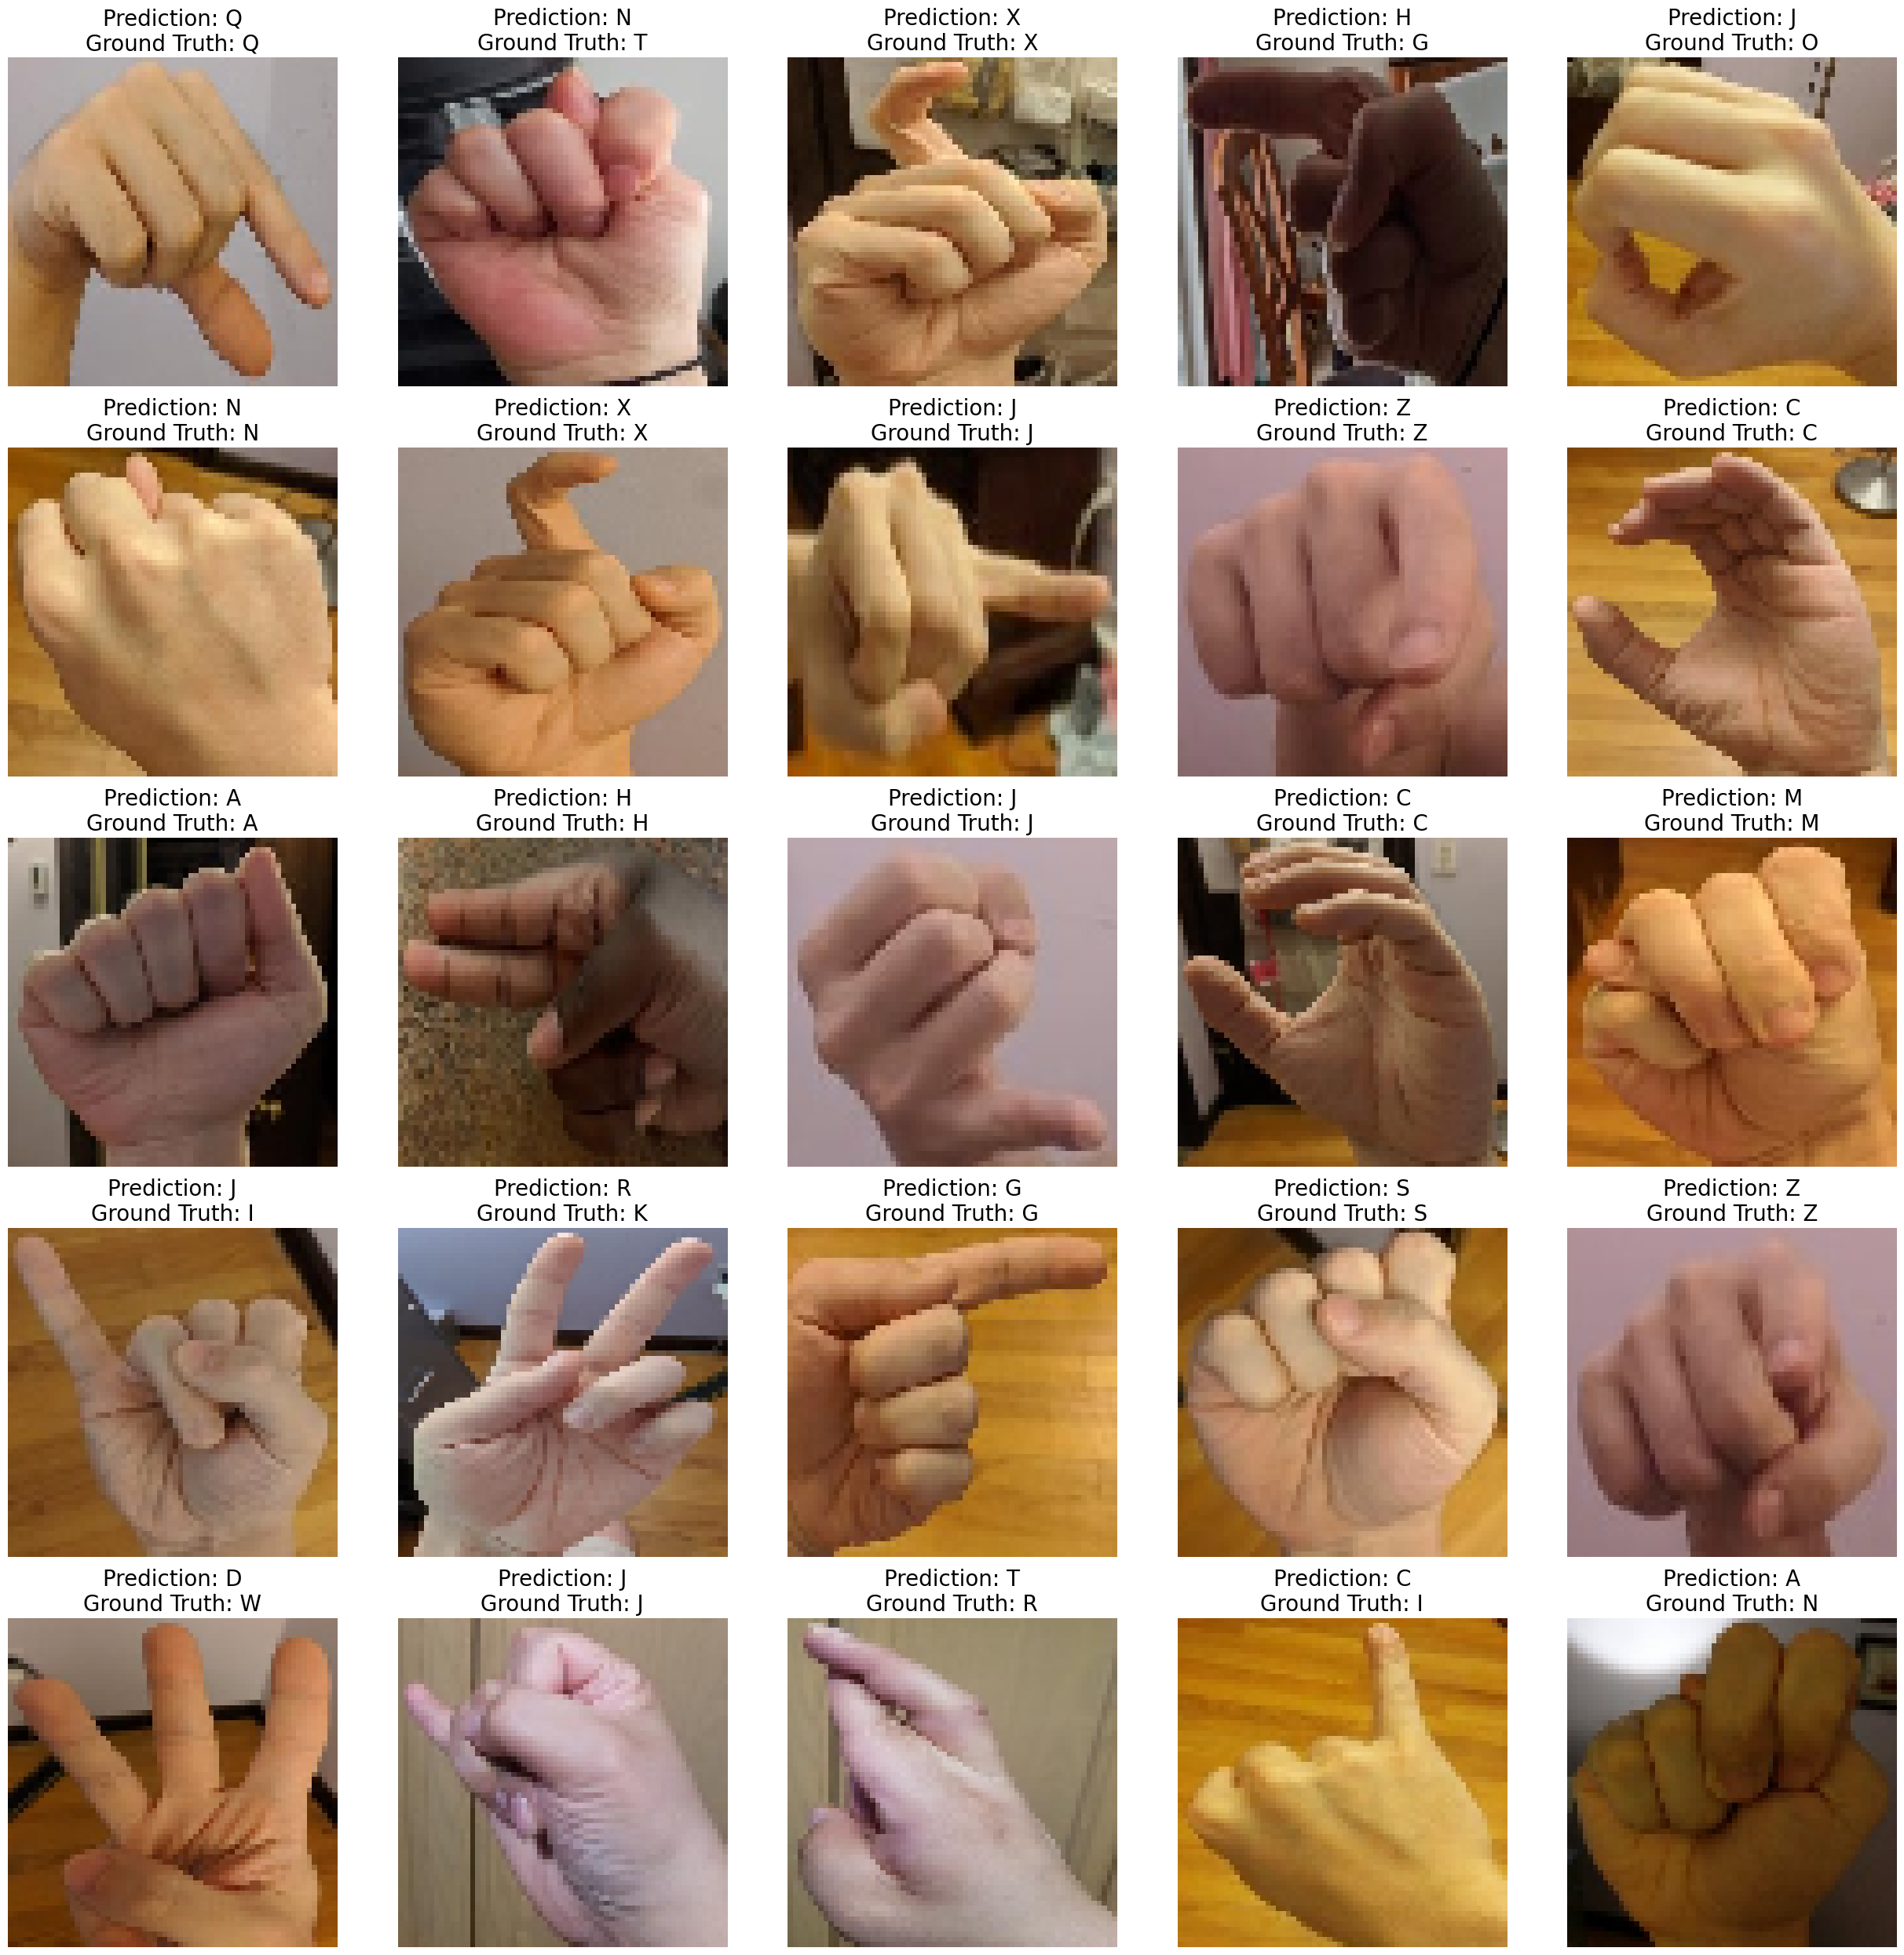

In [10]:
accuracy = test_model(model, annotations, processed_folder, train_generator)

In [11]:
#Display accuracy
print(round(accuracy, 3))

0.722


In [10]:
def evaluate_model(model, annotations, processed_folder, train_generator):
    """
    Evaluates a trained model on preprocessed test images and calculates F1 score and confusion matrix.

    Args:
    - model: a trained Keras model
    - annotations: a pandas DataFrame containing the annotations for the test images
    - processed_folder: the path to the folder containing the preprocessed test images
    - train_generator: the ImageDataGenerator used to generate the training data

    Returns:
    - F1 score and displays the confusion matrix
    """
    y_true = []
    y_pred = []

    # Iterate through all images in the test folder
    for file in os.listdir(processed_folder):

        output_image_path = os.path.join(processed_folder, file)

        # Load the preprocessed image and convert it to an array
        test_image = load_img(output_image_path, target_size=(64, 64))
        test_image_array = img_to_array(test_image)

        # Preprocess the image array
        test_image_array = test_image_array / 255.0
        test_image_array = np.expand_dims(test_image_array, axis=0)

        # Make a prediction
        predictions_ = model.predict(test_image_array)

        # Find the class with the highest probability
        predicted_class_index = np.argmax(predictions_[0])

        # Retrieve the corresponding label
        class_indices = train_generator.class_indices
        index_to_class_name = {index: name for name, index in class_indices.items()}
        predicted_class_name = index_to_class_name[predicted_class_index]

        # Get the ground truth class name
        ground_truth_annotation = annotations.loc[annotations["filename"] == file]
        ground_truth_class_name = ground_truth_annotation["class"].values[0]

        y_true.append(ground_truth_class_name)
        y_pred.append(predicted_class_name)

    # Get unique labels from y_true and y_pred
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, labels=unique_labels, average='weighted')
    f1 = round(f1, 3)

    # Confusion Matrix
    cf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)
    
    # Change the figure background color
    plt.rcParams['figure.facecolor'] = 'lightgrey'
    plt.rcParams['axes.facecolor'] = 'lightgrey'
    plt.rcParams['text.color'] = 'black'

    # Visualize Confusion Matrix
    plt.figure(figsize=(10,10))
    sns.heatmap(cf_matrix, annot=True, fmt="d", cmap='Blues', 
                xticklabels=unique_labels, 
                yticklabels=unique_labels,
                cbar=False, mask=cf_matrix == 0)
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('True', fontsize=15)
    plt.show()

    print(f"F1 Score: {f1}")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=unique_labels))

    return f1

1/1 [==============================] - 0s 30ms/step


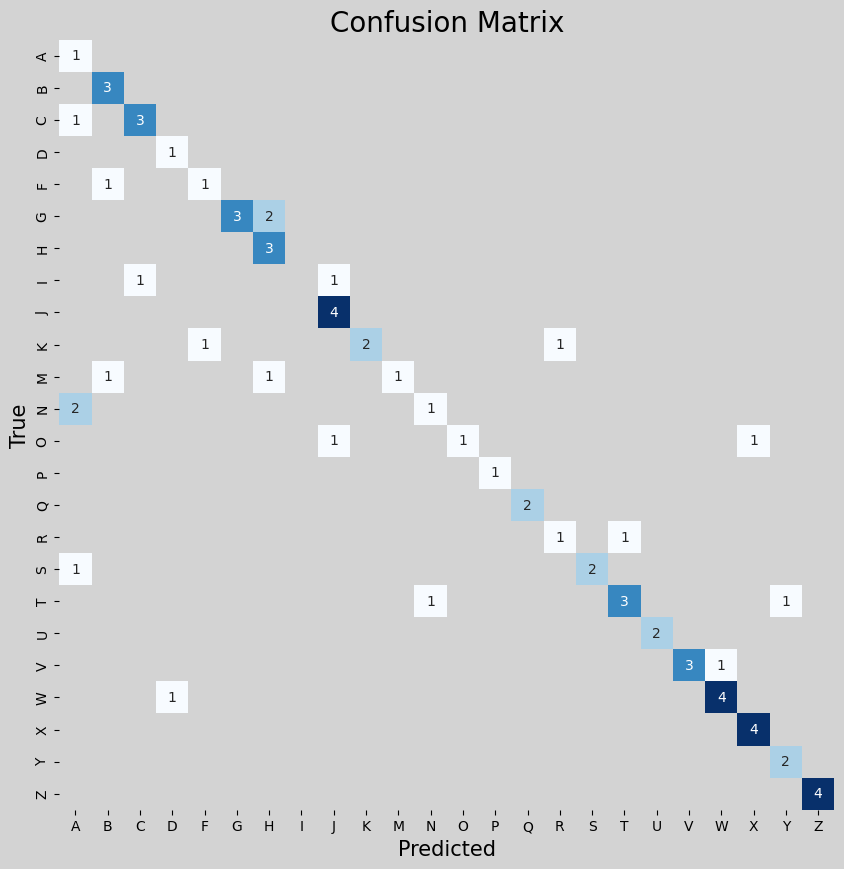

F1 Score: 0.714
              precision    recall  f1-score   support

           A       0.20      1.00      0.33         1
           B       0.60      1.00      0.75         3
           C       0.75      0.75      0.75         4
           D       0.50      1.00      0.67         1
           F       0.50      0.50      0.50         2
           G       1.00      0.60      0.75         5
           H       0.50      1.00      0.67         3
           I       0.00      0.00      0.00         2
           J       0.67      1.00      0.80         4
           K       1.00      0.50      0.67         4
           M       1.00      0.33      0.50         3
           N       0.50      0.33      0.40         3
           O       1.00      0.33      0.50         3
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      1.00         2
           R       0.50      0.50      0.50         2
           S       1.00      0.67      0.80         3
           

/nfs/home/rsk6167/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nfs/home/rsk6167/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/nfs/home/rsk6167/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.714

In [11]:
# Get confusion matrix and F1 score
evaluate_model(model, annotations, processed_folder, train_generator)